# Generation of synthetic imaged using copypaste data augmentation

In [3]:
# switch to the project directory
import os
os.chdir('..')
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/p22g5/AnomaliesRecycling


In [4]:
from data_augmentation.data_augmentation import DataAugmentation
dataAugm = DataAugmentation(
    zero_lid_dir='data_augmentation/data/zero_lid.csv',
    one_lid_dir='data_augmentation/data/one_lid.csv'
)


## Generation of the heatmap of lid objects

Generating and saving masks for images


100%|███████████████████████████████████████████████████████████| 1072/1072 [00:57<00:00, 18.75it/s]


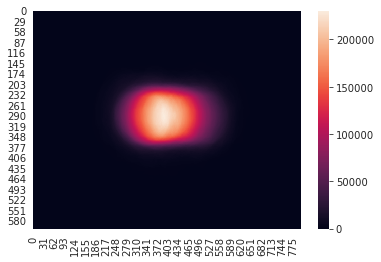

In [5]:
dataAugm.extract_masks()
summed_mask = dataAugm.get_sum_binary_mask()

## Generation of the percentiled binary mask
Use it for the center of the inserted objects

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

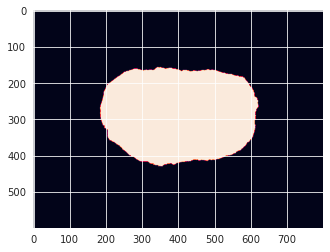

In [6]:
dataAugm.get_percentile_sum_binary_mask(summed_mask=summed_mask, percentile=80)

## Test copypaste method on one image

In [7]:
from PIL import Image
import cv2
from IPython.display import display
def show_cv(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    display(Image.fromarray(img))

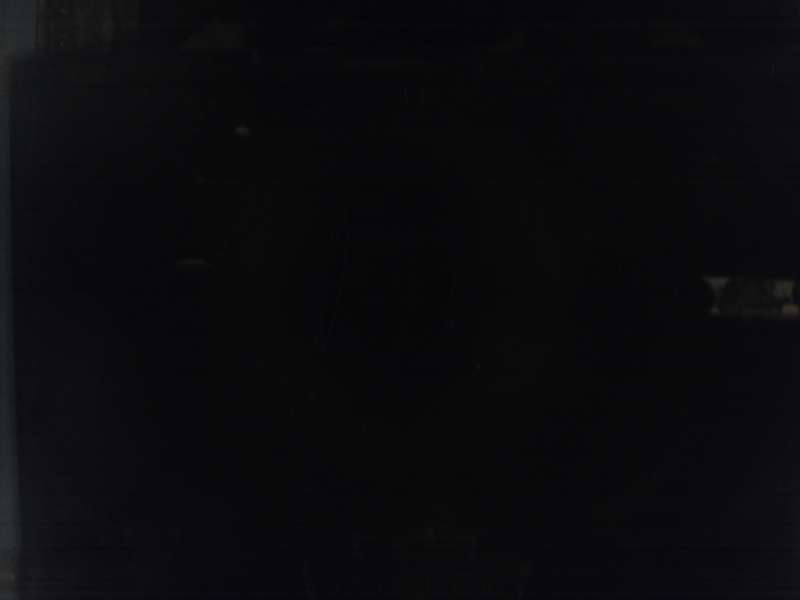

In [9]:
img, _ , _= dataAugm.copy_and_paste(label=0, noise_background=True, rotate=True, change_color=True, make_edge=True, make_dark=False, make_transparent=True)
show_cv(img)

## Generation of the synthesized image of required classes

In [10]:
dataAugm.generate({0: 2000,
                   1: 2000,
                   2: 2000,
                   3: 2000,
                   4: 2000,
                   5: 2000,
                   }, noise_background=True, rotate=True, change_color=True, make_edge=True, make_dark=True, make_transparent=True, coco_annotation=True,  data_dir_name='train')

Generate images:


100%|█████████████████████████████████████████████████████████| 12000/12000 [21:25<00:00,  9.33it/s]


Create coco annotation:


  0%|▏                                                        | 126/30000 [00:38<2:04:21,  4.00it/s]/home/p22g5/anaconda3/envs/recycling2/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
 17%|█████████▋                                              | 5216/30000 [21:01<1:38:04,  4.21it/s]/home/p22g5/anaconda3/envs/recycling2/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
100%|███████████████████████████████████████████████████████| 30000/30000 [1:56:07<00:00,  4.31it/s]


In [11]:
dataAugm.generate({0: 400,
                   1: 400,
                   2: 400,
                   3: 400,
                   4: 400,
                   5: 400,
                   }, noise_background=True, rotate=True, change_color=True, make_edge=True, make_dark=True, make_transparent=True, coco_annotation=True,  data_dir_name='test')

Generate images:


100%|███████████████████████████████████████████████████████████| 2400/2400 [03:38<00:00, 10.98it/s]


Create coco annotation:


  1%|▌                                                            | 61/6000 [00:15<26:19,  3.76it/s]/home/p22g5/anaconda3/envs/recycling2/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
100%|███████████████████████████████████████████████████████████| 6000/6000 [22:43<00:00,  4.40it/s]
